### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2
!pip install gdown tensorboard

------------

## Pixelwise Regression Tutorial (AGB Data)

### Download the dataset

In [2]:
import os
import gdown
import zipfile
from pathlib import Path

if not os.path.isfile('granite-geospatial-biomass-dataset.zip'):
    gdown.download("https://drive.google.com/uc?id=1s0i_gGL8_zWha3V3yV2MGCPg20YL2y96")

if not os.path.isdir('granite-geospatial-biomass-dataset/'):
    with zipfile.ZipFile('granite-geospatial-biomass-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('granite-geospatial-biomass-dataset')

In [3]:
dataset_path = Path('granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset')
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset"

test_images  test_labels  train_images train_labels val_images   val_labels


### Build datamodule

In [ ]:
from terratorch.datamodules import GenericNonGeoPixelwiseRegressionDataModule
import albumentations as A

datamodule = GenericNonGeoPixelwiseRegressionDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,
    check_stackability = False,
    
    # Define dataset paths 
    train_data_root=dataset_path / 'train_images/',
    train_label_data_root=dataset_path / 'train_labels/',
    val_data_root=dataset_path / 'val_images/',
    val_label_data_root=dataset_path / 'val_labels/',
    test_data_root=dataset_path / 'test_images/',
    test_label_data_root=dataset_path / 'test_labels/',
    
    img_grep='*.tif',
    label_grep='*.tif',
    
    train_transform=[
        A.D4(), # Random flips and rotation
        A.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
        
    # Define standardization values
    means=[
      547.36707,
      898.5121,
      1020.9082,
      2665.5352,
      2340.584,
      1610.1407,
    ],
    stds=[
      411.4701,
      558.54065,
      815.94025,
      812.4403,
      1113.7145,
      1067.641,
    ],
    dataset_bands = [-1, "BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2", -1, -1, -1, -1],
    output_bands = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    rgb_indices = [2, 1, 0],
    no_data_replace=0,
    no_label_replace=-1,
)

# Setup train and val datasets
datamodule.setup("fit")

In [5]:
train_dataset = datamodule.train_dataset
val_dataset = datamodule.val_dataset

print(f"Available samples in the training dataset: {len(train_dataset)}")
print(f"Available samples in the validation dataset: {len(val_dataset)}")
print(f"Input shape of first sample: {val_dataset[0]['image'].shape}")

Available samples in the training dataset: 1622
Available samples in the validation dataset: 406
Input shape of first sample: torch.Size([6, 224, 224])


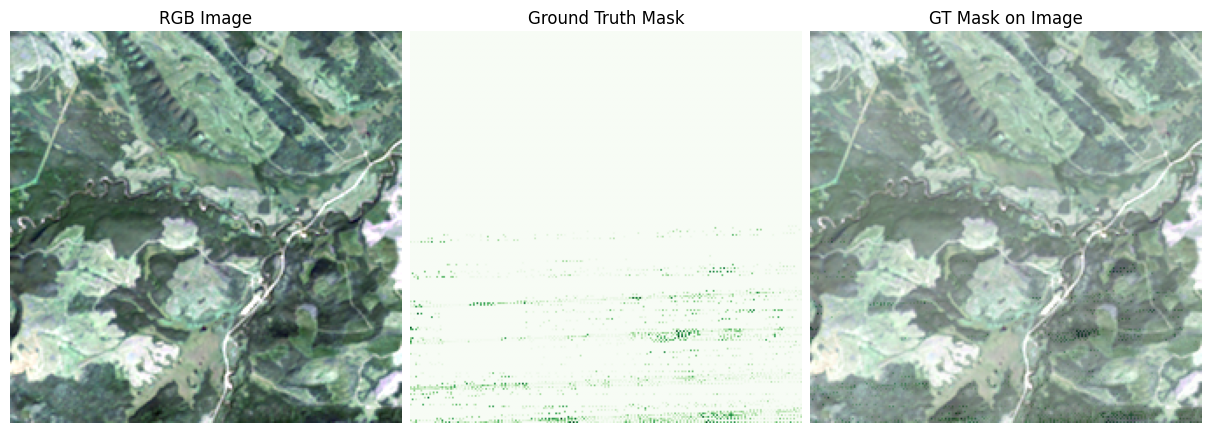

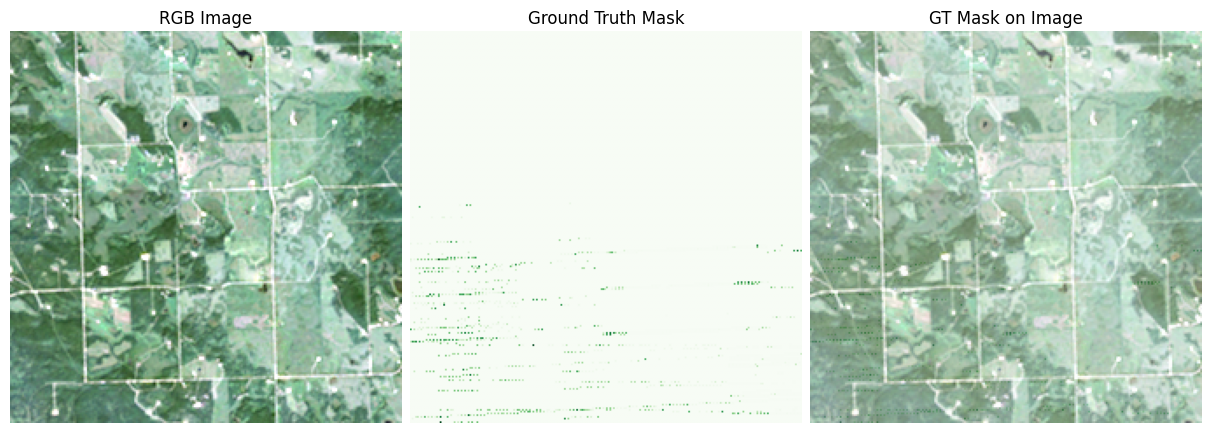

In [9]:
for i in range(2):
    _ = val_dataset.plot(val_dataset[i])

In [10]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset

print(f"Available samples in the test dataset: {len(test_dataset)}")

Available samples in the test dataset: 360


### Build training pipeline to finetune Prithvi

In [ ]:
from terratorch.tasks import PixelwiseRegressionTask
import lightning.pytorch as pl

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/agb/checkpoints/",
    monitor="val/RMSE",          # metric to monitor
    mode="min",
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1,                  # single device for notebook stability
    precision="16-mixed",        # speed up training
    num_nodes=1,
    logger=True,                # uses TensorBoard by default
    max_epochs=1,               # demo only
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/agb",
    detect_anomaly=True,
)

# Model
model = PixelwiseRegressionTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300",  # prithvi_eo_v1_100 / prithvi_eo_v2_300 / *_tl / *_600
        "backbone_pretrained": True,
        "backbone_num_frames": 1,
        # "backbone_img_size": 224,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": ["time", "location"],

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11],   # prithvi_eo_v1_100
                "indices": [5, 11, 17, 23],  # prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31], # prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage"},
            {"name": "LearnedInterpolateToPyramidal"},
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        # "head_dropout": 0.16194593880230534,
        # "head_final_act": torch.nn.ReLU,
        # "head_learned_upscale_layers": 2,
    },
    loss="rmse",
    optimizer="AdamW",
    lr=1e-3,
    ignore_index=-1,
    freeze_backbone=True,        # speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

### Evaluate model and inference

In [ ]:
best_ckpt_path = "output/agb/checkpoints/best-epoch=00.ckpt"

# Evaluate the model on the test set
_ = trainer.test(model=model, datamodule=datamodule, ckpt_path=best_ckpt_path)

In [ ]:
import torch 

# Normalization statistics
means = [547.36707, 898.5121, 1020.9082, 2665.5352, 2340.584, 1610.1407]
stds = [411.4701, 558.54065, 815.94025, 812.4403, 1113.7145, 1067.641]

test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(model.device)

    # Apply the same normalization used during training
    mean = torch.tensor(means, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    std = torch.tensor(stds, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    images_norm = (images - mean) / std

    outputs = model(images_norm)
    preds = outputs.output

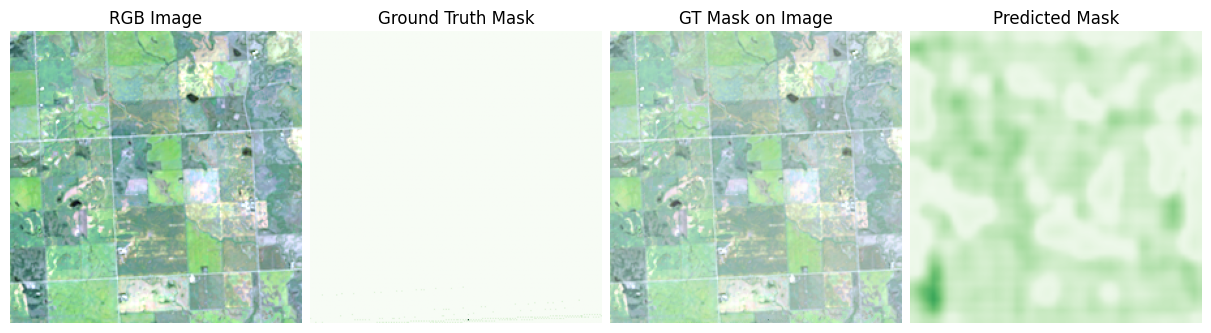

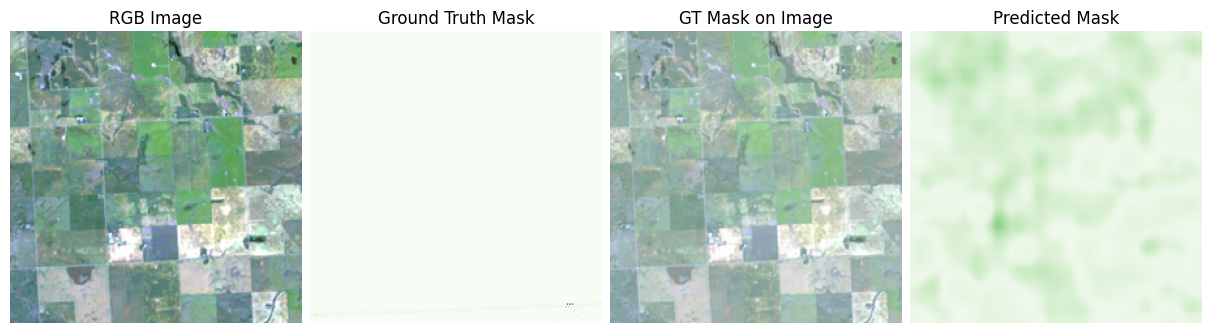

In [19]:
# Visualize a few predictions
test_dataset = datamodule.test_dataset

for i in range(2,4):
    sample = {key: batch[key][i] for key in batch}
    sample["image"] = sample["image"].cpu()
    sample["mask"] = sample["mask"].cpu()
    sample["prediction"] = preds[i]

    test_dataset.plot(sample)

In [ ]:
import os
best_ckpt_100_epoch_path = "agb_best-epoch=68.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-")

# Evaluate the model on the test set
_ = trainer.test(model=model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

In [ ]:
import torch

# Normalization statistics
means = [547.36707, 898.5121, 1020.9082, 2665.5352, 2340.584, 1610.1407]
stds = [411.4701, 558.54065, 815.94025, 812.4403, 1113.7145, 1067.641]

test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(model.device)

    # Apply the same normalization used during training
    mean = torch.tensor(means, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    std = torch.tensor(stds, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    images_norm = (images - mean) / std

    outputs = model(images_norm)
    preds = outputs.output

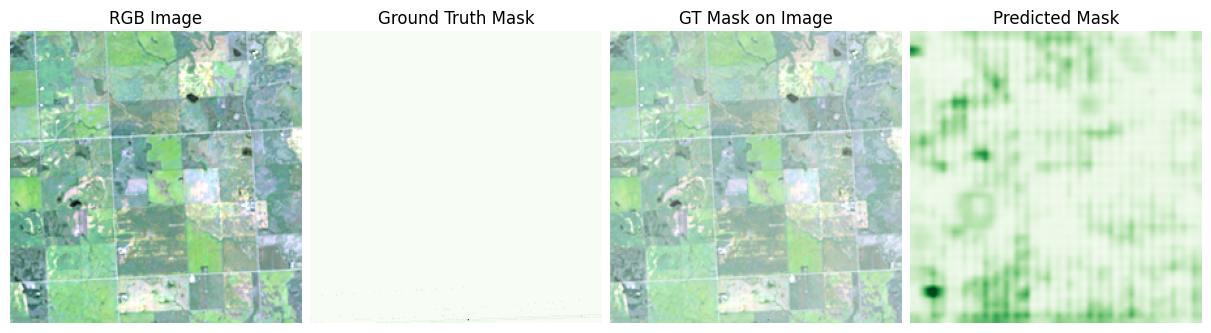

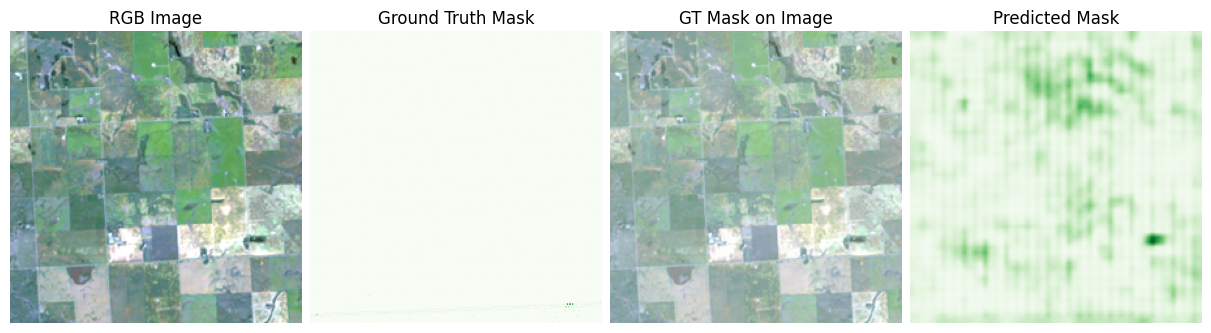

In [22]:
# Visualize a few predictions
test_dataset = datamodule.test_dataset

for i in range(2,4):
    sample = {key: batch[key][i] for key in batch}
    sample["image"] = sample["image"].cpu()
    sample["mask"] = sample["mask"].cpu()
    sample["prediction"] = preds[i]

    test_dataset.plot(sample)

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [ ]:
# Run fine-tuning
!terratorch fit -c pixelwise_regression_agb.yaml